In [ ]:
!pip install tensorflow==2.19.0

In [1]:
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf

In [2]:
image_dir = "C:/Users/HP/Desktop/ML_DS/CNN/data/oxford-iiit-pet/images/images"
annotations_file = "C:/Users/HP/Desktop/ML_DS/CNN/data/oxford-iiit-pet/annotations/annotations/list.txt"

In [3]:
with open(annotations_file, "r") as f:
    lines = f.readlines()[6:]

data = []
for line in lines:
    parts = line.strip().split()
    if len(parts) >= 2:
        filename = parts[0] + ".jpg"
        label = "_".join(parts[0].split("_")[:-1])
        full_path = os.path.join(image_dir, filename)
        if os.path.exists(full_path):
            data.append((full_path, label))

In [4]:
class_names = sorted(set(label for _, label in data))
label_to_index = {name: idx for idx, name in enumerate(class_names)}
full_data = [(img, label_to_index[label]) for img, label in data]

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(full_data, test_size=0.2, random_state=42, stratify=[label for _, label in full_data])

test_images = [img for img, _ in test_data]
true_labels = [label for _, label in test_data]

In [6]:
baseline_model = tf.keras.models.load_model("C:/Users/HP/Desktop/ML_DS/CNN//notebooks/model/best_model.h5")
augmented_model = tf.keras.models.load_model("C:/Users/HP/Desktop/ML_DS/CNN//notebooks/augmented_model/best_model.h5")

In [10]:
def preprocess_image(img_path):
    img = Image.open(img_path).resize((224, 224))
    img = np.array(img) / 255.0
    return np.expand_dims(img, axis=0) 

def get_class_name(pred, class_names):
    return class_names[np.argmax(pred)]

disagree_samples = []
for i in range(len(test_images)):
    img_path = test_images[i]
    true_label = true_labels[i]
    
    img_tensor = preprocess_image(img_path)

    pred_base = baseline_model.predict(img_tensor, verbose=0)
    pred_aug = augmented_model.predict(img_tensor, verbose=0)

    base_pred_label = np.argmax(pred_base)
    aug_pred_label = np.argmax(pred_aug)

    if base_pred_label != aug_pred_label:
        disagree_samples.append((img_path, true_label, base_pred_label, aug_pred_label))

    if len(disagree_samples) >= 10:
        break

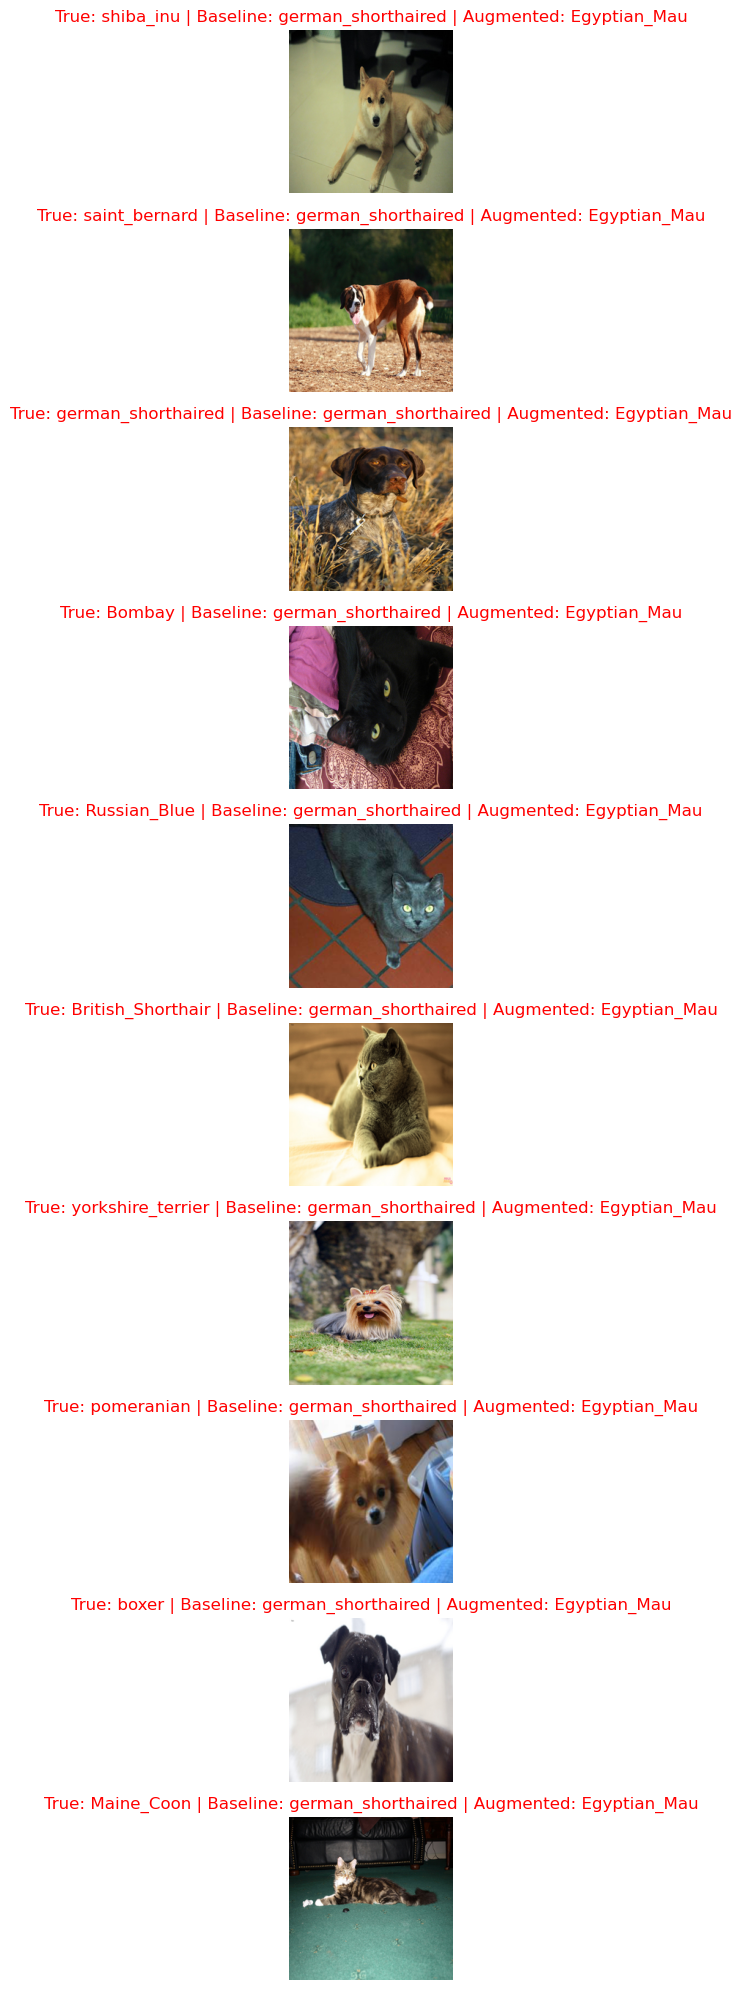

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 20))
for idx, (img_path, true_idx, base_idx, aug_idx) in enumerate(disagree_samples):
    img = Image.open(img_path).resize((224, 224))
    
    plt.subplot(10, 1, idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {class_names[true_idx]} | Baseline: {class_names[base_idx]} | Augmented: {class_names[aug_idx]}", 
              fontsize=12, 
              color=("green" if aug_idx == true_idx else "red"))
plt.tight_layout()
plt.show()